In [1]:
import matplotlib.pyplot as plt
import numpy as np
from amuse.units import units
import matplotlib.ticker

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Create velocity.txt and density.txt for the data from Xiao

# r = np.linspace(0.05, 0.50, 1000)
r = np.loadtxt("mdot9disk20220601/rad_chart.txt")

def load_data(name):
    _r, _l = np.loadtxt(f"mdot9disk20220601/{name}.txt").T
    # return interp1d(_r, _l, kind="quadratic")(r)
    return _l

# Merge velocity files
vt_gas = load_data("vt_gas")
vr_gas = load_data("vr_gas")

velocity = np.column_stack([r, vt_gas, vr_gas])
# np.savetxt("velocity.txt", velocity, fmt="%.6e")

# Calculate density
T = load_data("temperature")
k_B = 1.3807e-16 # cm^2 g s^-2 K^-1
m_p = 1.66e-24; mu = 2.33; gamma = 1.0
c_s = np.sqrt(gamma * k_B * T / (mu * m_p)) # cm s^-1

r_cm = r * 14959787069100
Ω = 2 * np.pi * (r ** (-3.0 / 2)) / (31558150) # s^-1
H = c_s / Ω
v_K = r_cm * Ω
# np.savetxt("scale_height_2.txt", np.column_stack([r, H]), fmt="%.6e")

rho_p = 3
v = v_K - vt_gas
va = np.abs(v)
vs = np.sign(v)

sigma = load_data("sigma")
rho_0 = sigma / (H * np.sqrt(2*np.pi))
# np.savetxt("midplane_density_2.txt", np.column_stack([r, rho_0]), fmt="%.6e")

alpha = load_data("alpha")

nd = sigma / (2 * H * m_p * mu)
la = 1 / (nd * 2e-15)
nu = la * c_s
_nu = alpha * c_s * H
eta = nu * rho_0

l = np.logical_and(r > 0.15, r < 0.35)
Re_a = 2 * va * rho_0 / eta

lM = np.linspace(-3, 0, 100)
M = np.power(10., lM)
M_cgs = M * 5.97e27
a = (M_cgs * 3 / (rho_p * 4 * np.pi))**(1. / 3)
Re = Re_a[:, np.newaxis] * a[np.newaxis, :]

# t_fric = np.zeros_like(Re)
# n = Re > 1.
# t_fric[n] = ((2**(.6) * rho_p * a[np.newaxis, :]**1.6) / (9 * (eta**.6 * rho_0**.4 * va**.4)[:, np.newaxis]))[n]
# n = np.logical_not(n)
# t_fric[n] = ((2 * rho_p * a[np.newaxis, :]**2.) / (9 * (eta)[:, np.newaxis]))[n]
# n = Re > 800.
# t_fric[n] = (6 * rho_p * a[np.newaxis, :] / (rho_0 * va)[:, np.newaxis])[n]

# t_fric = ((2 * rho_p * a[np.newaxis, :]**2.) / (9 * (eta)[:, np.newaxis]))

C_D = 1.0
F_D = -0.5 * C_D * np.pi * (a**2.)[np.newaxis, :] * (rho_0 * va**2. * vs)[:, np.newaxis]
a_D = F_D / (M * 5.97e27)[np.newaxis, :]
t_fric = -(M * 5.97e27)[np.newaxis, :] * v[:, np.newaxis] / F_D

tau = t_fric * Ω[:, np.newaxis]

_eta = 1 - np.square(vt_gas / v_K)
v_rp = (-_eta * v_K)[:, np.newaxis] / (tau + 1. / tau)

In [5]:
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)

def g(value, _):
    if value == 0.0:
        return "0"

    e = np.floor(np.log10(np.abs(value)))
    s = np.round(value / 10**e, 10)
    exponent = "%d" % e
    significand = ("%d" if s % 1 == 0 else "%1.02f") % s
    exponent = "10^{%s}" % exponent
    return (f"${exponent}$" if s == 1 else f"${significand} \\times {exponent}$")

tickformat = mticker.FuncFormatter(g)

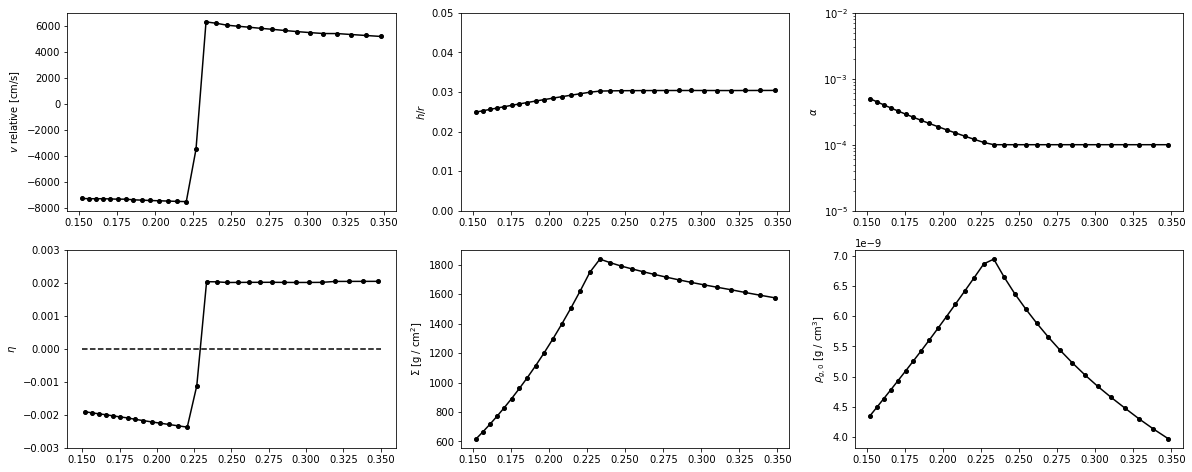

In [6]:
from matplotlib.rcsetup import cycler

plt.rc('axes', prop_cycle=(cycler(marker=['o'], ms=[4])))

fig, _axs = plt.subplots(2, 3, figsize=(20, 8))
axs = np.ravel(_axs)

axs[0].plot(r[l], v[l])
axs[0].set_ylabel("$v$ relative [cm/s]")

axs[1].plot(r[l], (H/r_cm)[l])
axs[1].set_ylim(0, 0.05)
axs[1].set_ylabel("$h/r$")

axs[2].plot(r[l], alpha[l])
axs[2].set_yscale("log")
axs[2].set_ylim(1e-5, 1e-2)
axs[2].set_ylabel("$\\alpha$")

axs[4].plot(r[l], sigma[l])
axs[4].set_ylabel("$\\Sigma$ [g / cm$^2$]")

axs[5].plot(r[l], rho_0[l])
axs[5].set_ylabel("$\\rho_{g,0}$ [g / cm$^3$]")

axs[3].hlines(0, 0.15, 0.35, linestyles="--", color="black")
axs[3].plot(r[l], _eta[l])
axs[3].set_ylim(-0.003, 0.003)
axs[3].set_ylabel("$\\eta$")
# axs[3].yaxis.set_major_formatter(tickformat)

plt.savefig("disk.png")

In [7]:
k = np.logical_and(l[:, np.newaxis], v_rp < 0.)
j = np.logical_not(k)

def contourf_blocked(x, **kwargs):
    x_k = x.copy()
    x_k[j] = np.nan
    x_j = x.copy()
    x_j[k] = np.nan

    plt.contourf(r[l], lM, x_j[l].T, **kwargs)
    plt.contourf(r[l], lM, x_k[l].T, **kwargs)

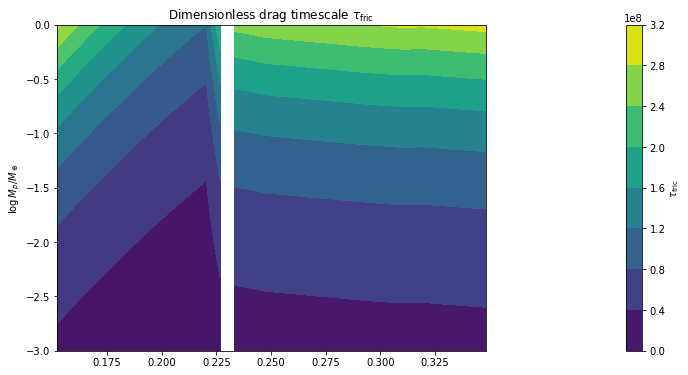

In [8]:
fig = plt.figure(figsize=(12, 6))
contourf_blocked(tau)
plt.ylabel("$\\log M_p / M_\oplus$")
plt.title("Dimensionless drag timescale $\\tau_{\\rm fric}$")
plt.colorbar(label="$\\tau_{\\rm fric}$")
b = plt.colorbar()
b.ax.set_visible(False)

plt.savefig("tau.png", bbox_extra_artists=b)

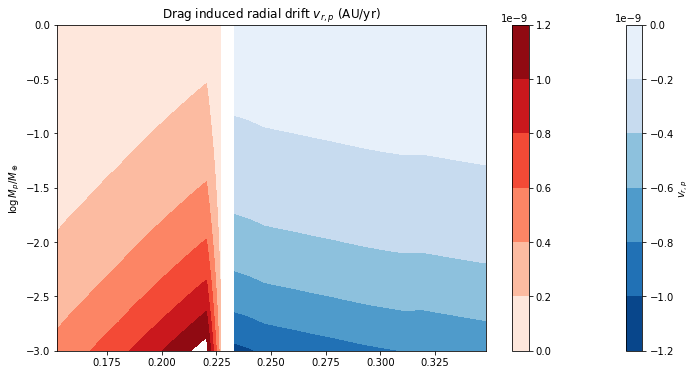

In [9]:
k = np.logical_and(l[:, np.newaxis], v_rp < 0.)
j = np.logical_not(k)

v_rp_k = v_rp.copy()
v_rp_k[k] = np.nan

v_rp_j = v_rp.copy()
v_rp_j[j] = np.nan

plt.figure(figsize=(12, 6))
a = plt.contourf(r[l], lM, (v_rp_k[l]).T * 2.109532e-6, np.arange(0, 12.1, 2)*1e-10, cmap="Reds")
b = plt.contourf(r[l], lM, (v_rp_j[l]).T * 2.109532e-6, -np.arange(0, 12.1, 2)[::-1]*1e-10, cmap="Blues_r")
plt.ylabel("$\\log M_p / M_\oplus$")
plt.title("Drag induced radial drift $v_{r,p}$ (AU/yr)")
plt.colorbar(b, label="$v_{r,p}$")
plt.colorbar(a, label="")
plt.savefig("v_r.png")

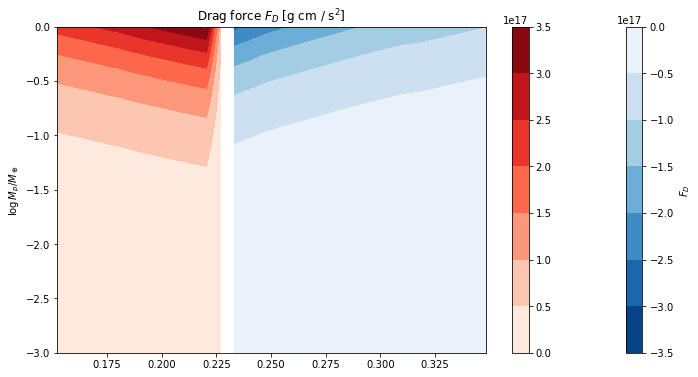

In [10]:

plt.figure(figsize=(12, 6))
a = plt.contourf(r[l], lM, np.ma.masked_where(k, F_D)[l].T, np.arange(0.0, 4e17, 0.5e17), cmap="Reds")
b = plt.contourf(r[l], lM, np.ma.masked_where(j, F_D)[l].T, np.arange(-3.5e17, 0.5e17, 0.5e17), cmap="Blues_r")
plt.ylabel("$\\log M_p / M_\oplus$")
plt.colorbar(b, label="$F_D$")
plt.colorbar(a)
plt.title("Drag force $F_D$ [g cm / s$^2$]")
plt.savefig("F_D.png")

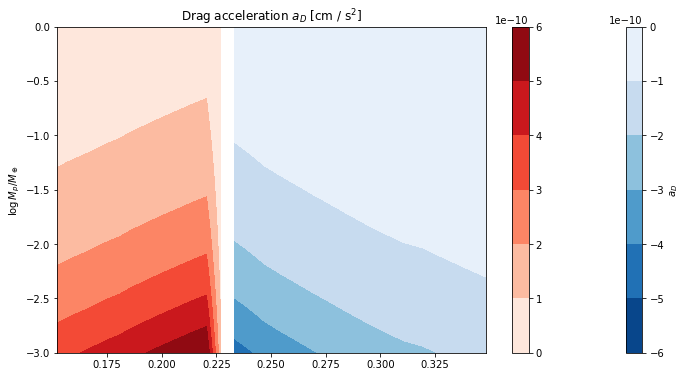

In [11]:
plt.figure(figsize=(12, 6))
a = plt.contourf(r[l], lM, np.ma.masked_where(k, a_D)[l].T, np.arange(0.0, 7e-10, 1.e-10), cmap="Reds")
b = plt.contourf(r[l], lM, np.ma.masked_where(j, a_D)[l].T, np.arange(-6e-10, 1e-10, 1.e-10), cmap="Blues_r")
plt.ylabel("$\\log M_p / M_\oplus$")
plt.colorbar(b, label="$a_D$")
plt.colorbar(a)
plt.title("Drag acceleration $a_D$ [cm / s$^2$]")
plt.savefig("a_D.png")

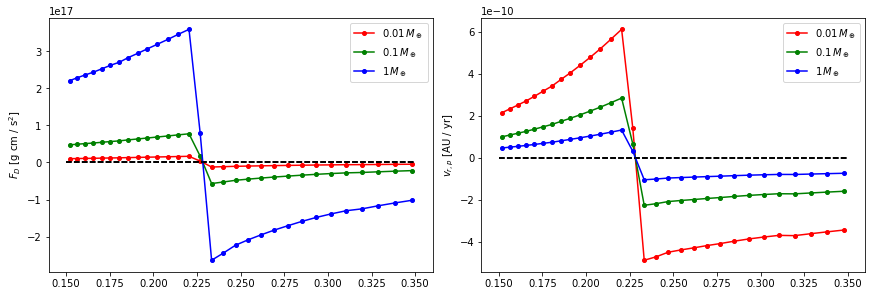

In [27]:
_i = [33, 66, 99]
n = ["0.01", "0.1", "1"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axs = np.ravel(axs)

plt.rc('axes', prop_cycle=(cycler(color=["r", "g", "b"]) * cycler(marker=['o'], ms=[4])))

for i, _n in zip(_i, n):
    axs[0].plot(r[l], F_D[l, i], label=f"${_n}\,M_\\oplus$")
    axs[0].hlines([0], 0.15, 0.35, linestyle="--", color="black")
    axs[0].legend()

    axs[1].plot(r[l], v_rp[l, i] * 2.109532e-6, label=f"${_n}\,M_\\oplus$")
    axs[1].hlines([0], 0.15, 0.35, linestyle="--", color="black")
    axs[1].legend()


axs[0].set_ylabel("$F_D$ [g cm / s$^2$]")
axs[1].set_ylabel("$v_{r,p} $ [AU / yr]")

plt.savefig("double.png")

Text(0.5, 1.0, 'Torque per gram (drag force)')

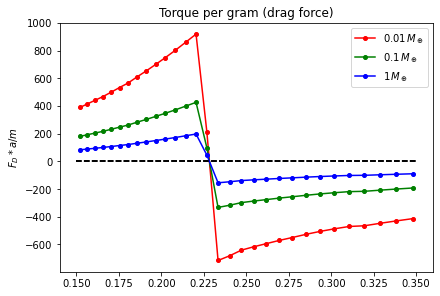

In [71]:
_i = [33, 66, 99]
n = ["0.01", "0.1", "1"]

fig, axs = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
axs = np.ravel(axs)

plt.rc('axes', prop_cycle=(cycler(color=["r", "g", "b"]) * cycler(marker=['o'], ms=[4])))

for i, _n in zip(_i, n):
    axs[0].plot(r[l], F_D[l, i] * r_cm[l] / M_cgs[i], label=f"${_n}\,M_\\oplus$")
    axs[0].hlines([0], 0.15, 0.35, linestyle="--", color="black")
    axs[0].legend()

    # axs[1].plot(r[l], v_rp[l, i] * 2.109532e-6, label=f"${_n}\,M_\\oplus$")
    # axs[1].hlines([0], 0.15, 0.35, linestyle="--", color="black")
    # axs[1].legend()


axs[0].set_ylabel("$F_D *  a / m$")
axs[0].set_title("Torque per gram (drag force)")
# axs[1].set_ylabel("$v_{r,p} $ [AU / yr]")

In [30]:
Tr, torque_01MG = np.loadtxt("torque/new_01MG_HR.txt").T
_, torque_05MG = np.loadtxt("torque/new_05MG_HR.txt").T
_, torque_1MG = np.loadtxt("torque/new_1MG_HR.txt").T

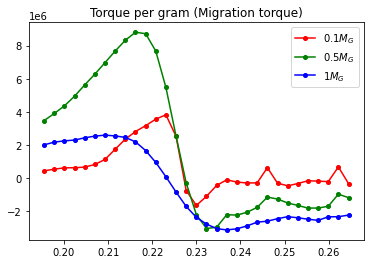

In [72]:
torque_scale_x = 2.3
TrS = Tr * torque_scale_x

i_ = 99

G_cgs = 6.67e-8
AU_cgs = 14959787069100
Msun_cgs = 2e33

plt.plot(TrS, torque_01MG * G_cgs * Msun_cgs / AU_cgs, label="$0.1 M_G$")
plt.plot(TrS, torque_05MG * G_cgs * Msun_cgs / AU_cgs, label="$0.5 M_G$")
plt.plot(TrS, torque_1MG * G_cgs * Msun_cgs  / AU_cgs, label="$1 M_G$")
plt.title("Torque per gram (Migration torque)")
plt.legend()

In [76]:
r[np.argmax(sigma)]

0.233345

In [75]:
print(f"{G_cgs * Msun_cgs / AU_cgs:6e}")

8.917239e+12


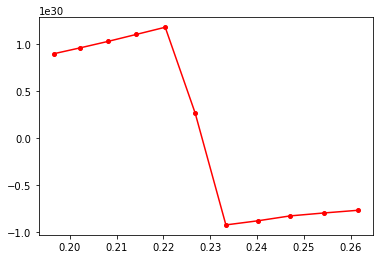

In [62]:
_l = np.logical_and(r > TrS[0], r < TrS[-1])
plt.plot(r[_l], F_D[_l, i_] * r_cm[_l])

In [42]:
interp1d(r, sigma)(1.0)

array(1038.1968339300272)

In [65]:
0.23 * AU_cgs * 3e17

1.0322253077679e+30

In [13]:
low = 0.20
high = 0.26

x_i = np.linspace(0.15, 0.35, 10000)

sigma_i = interp1d(r, sigma, kind='cubic')(x_i)
rho_i = interp1d(r, rho_0, kind='cubic')(x_i)

(-10.0, 10.0)

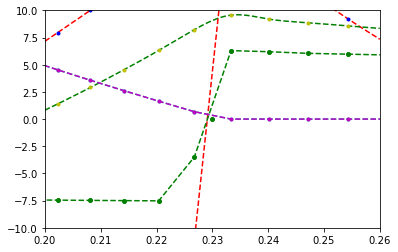

In [14]:
plt.plot(x_i, rho_i * 1e10 - 52, "--")
plt.plot(r, rho_0 * 1e10 - 52, "bo",  ms=3)

plt.plot(x_i, sigma_i * 0.015 - 18, "--")
plt.plot(r, sigma * 0.015 - 18, "yo",  ms=3)

plt.plot(r, _eta * 1e4, "r--o")
plt.plot(r, v * 1e-3, "g--o")

plt.plot(r, np.log10(alpha)*20 + 80, "c--o",  ms=3)
alpha_p = np.poly1d([-6.6333076, -4.3837696, -0.37942259][::-1])(np.log10(r))
alpha_p[r > 0.232] = -4
plt.plot(r, alpha_p*20 + 80, "m--o",  ms=3)

plt.plot(0.23, 0)

plt.xlim(low, high)
plt.ylim(-10, 10)

(-5.0, -2.0)

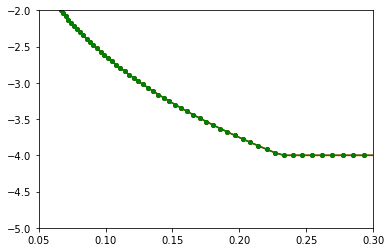

In [15]:
alpha_p = np.poly1d([-6.6333076, -4.3837696, -0.37942259][::-1])(np.log10(r))
alpha_p[r > 0.232] = -4
plt.plot(r, alpha_p)
plt.plot(r, np.log10(alpha))
plt.xlim(0.05, 0.30)
plt.ylim(-5, -2)

In [16]:
from glob import glob
from pathlib import Path
import re

In [17]:
lr = re.compile(r"\-?(?:[0-9]+\.)?[0-9]+(?:e[+-][0-9]{2})?")

runs = {}

for fn in glob("../sim/rebforces/test/simon/simon_simulations_20220712/iopf_csim*/output.txt"):
    p = Path(fn)
    run = p.parent.name

    with open(p, "r") as f:
        lines = f.readlines()

        _t = []
        _a = []
        _e = []
        _Da = []
        _De = []
        for i in range(41 * 7, len(lines), 7):
            _t.append(float(re.findall(lr, lines[i])[0]))
            _a.append(float(re.findall(lr, lines[i+5])[0]))
            _e.append(float(re.findall(lr, lines[i+5])[1]))
            _Da.append(float(re.findall(lr, lines[i+5])[2]))
            _De.append(float(re.findall(lr, lines[i+5])[3]))

        runs[run] = {
            "t": np.array(_t),
            "a": np.array(_a),
            "e": np.array(_e),
            "Da": np.array(_Da),
            "De": np.array(_De)
        }

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('axes', prop_cycle=(cycler(color=["b", "g", "r"])))

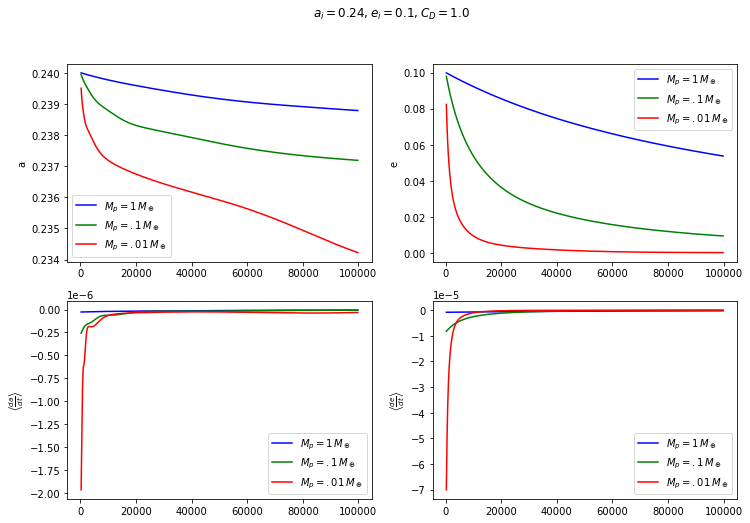

In [19]:
a_i = "0.24"
e_i = "0.1"

r0 = runs[f"iopf_csim_DRAG_1.0_{a_i}_{e_i}_1.0"]
r1 = runs[f"iopf_csim_DRAG_0.1_{a_i}_{e_i}_1.0"]
r2 = runs[f"iopf_csim_DRAG_0.01_{a_i}_{e_i}_1.0"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.ravel()

fig.suptitle(f"$a_i = {a_i}, e_i = {e_i}, C_D = 1.0$")

axs[0].plot(r0["t"], r0["a"], label="$M_p = 1\,M_\oplus$") 
axs[0].plot(r1["t"], r1["a"], label="$M_p = .1\,M_\oplus$")
axs[0].plot(r2["t"], r2["a"], label="$M_p = .01\,M_\oplus$")
axs[0].set_ylabel("a")

axs[0].legend()

axs[1].plot(r0["t"], r0["e"], label="$M_p = 1\,M_\oplus$")
axs[1].plot(r1["t"], r1["e"], label="$M_p = .1\,M_\oplus$")
axs[1].plot(r2["t"], r2["e"], label="$M_p = .01\,M_\oplus$")
axs[1].set_ylabel("e")

axs[1].legend()

axs[2].plot(r0["t"], r0["Da"], label="$M_p = 1\,M_\oplus$") 
axs[2].plot(r1["t"], r1["Da"], label="$M_p = .1\,M_\oplus$")
axs[2].plot(r2["t"], r2["Da"], label="$M_p = .01\,M_\oplus$")
axs[2].set_ylabel(r"$\left<\frac{da}{dt}\right>$")

axs[2].legend()

axs[3].plot(r0["t"], r0["De"], label="$M_p = 1\,M_\oplus$")
axs[3].plot(r1["t"], r1["De"], label="$M_p = .1\,M_\oplus$")
axs[3].plot(r2["t"], r2["De"], label="$M_p = .01\,M_\oplus$")
axs[3].set_ylabel(r"$\left<\frac{de}{dt}\right>$")

axs[3].legend()

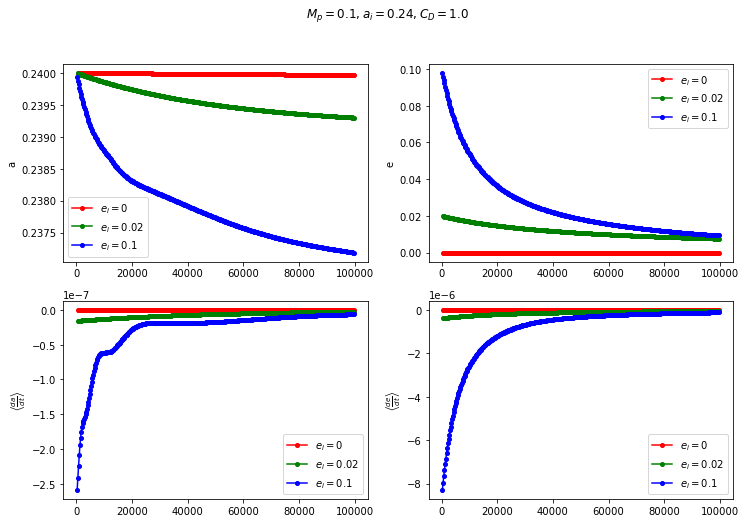

In [78]:
a_i = "0.24"
M_p = "0.1"

r0 = runs[f"iopf_csim_DRAG_{M_p}_{a_i}_0_1.0"]
r1 = runs[f"iopf_csim_DRAG_{M_p}_{a_i}_0.02_1.0"]
r2 = runs[f"iopf_csim_DRAG_{M_p}_{a_i}_0.1_1.0"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.ravel()

fig.suptitle(f"$M_p = {M_p}, a_i = {a_i}, C_D = 1.0$")

axs[0].plot(r0["t"], r0["a"], label="$e_i = 0$")
axs[0].plot(r1["t"], r1["a"], label="$e_i = 0.02$")
axs[0].plot(r2["t"], r2["a"], label="$e_i = 0.1$")
axs[0].set_ylabel("a")

axs[0].legend()

axs[1].plot(r0["t"], r0["e"], label="$e_i = 0$")
axs[1].plot(r1["t"], r1["e"], label="$e_i = 0.02$")
axs[1].plot(r2["t"], r2["e"], label="$e_i = 0.1$")
axs[1].set_ylabel("e")

axs[1].legend()

axs[2].plot(r0["t"], r0["Da"], label="$e_i = 0$")
axs[2].plot(r1["t"], r1["Da"], label="$e_i = 0.02$")
axs[2].plot(r2["t"], r2["Da"], label="$e_i = 0.1$")
axs[2].set_ylabel(r"$\left<\frac{da}{dt}\right>$")

axs[2].legend()

axs[3].plot(r0["t"], r0["De"], label="$e_i = 0$")
axs[3].plot(r1["t"], r1["De"], label="$e_i = 0.02$")
axs[3].plot(r2["t"], r2["De"], label="$e_i = 0.1$")
axs[3].set_ylabel(r"$\left<\frac{de}{dt}\right>$")

axs[3].legend()

In [21]:
eta2 = _eta / 2 # The value of eta used in Adachi (1976)

Text(0, 0.5, '-$\\left<\\frac{de}{dt}\\right>$ [s$^{-1}$]')

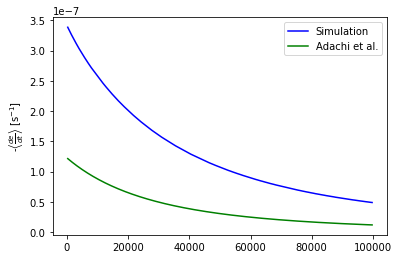

In [22]:
t40_2 = r1["t"]
a40_2 = r1["a"]
e40_2 = r1["e"]
Da40_2 = r1["Da"]
De40_2 = r1["De"]

plt.plot(t40_2, -De40_2, label="Simulation")

rho0_e2 = interp1d(r, rho_0)(a40_2)
vK_e2 = interp1d(r, v_K)(a40_2)
Ω_e2 = interp1d(r, Ω)(a40_2)

s = (M * 5.97e27 * 3 / (rho_p * 4 * np.pi))**(1. / 3)
tf_e2 = 2 * (5.97e27 * M[66]) / (np.pi * 1.0 * (s[66]**2) * rho0_e2 * vK_e2)

T_k_e2 = (2 * np.pi / Ω_e2)
tf_e2_alt = 365 * (5.97e6 * M[66])**(1./3) * T_k_e2 / (a40_2 * 14959787069100 / 1.5e13) / (rho0_e2 / 1e-9)

eta2_e2 = interp1d(r, eta2)(a40_2)
abs_eta2_e2 = np.abs(eta2_e2)

plt.plot(t40_2, 31558150 * e40_2 * (0.77 * e40_2 + eta2_e2) / tf_e2, label="Adachi et al.")
plt.legend()
plt.ylabel(r"-$\left<\frac{de}{dt}\right>$ [s$^{-1}$]")


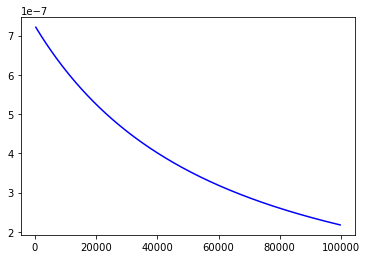

In [23]:
plt.plot(t40_2, T_k_e2 * (eta2_e2 + e40_2) / tf_e2)

In [24]:
np.median(-De40_2 / (31558150 * e40_2 * (0.77 * e40_2 + abs_eta2_e2) / tf_e2))

2.6469998916488264

In [25]:
interp1d(r, vt_gas)(0.24)

array(6073615.02795031)